## 第10組：期末報告
### 資料說明

本專案資料來源於 Google Play 爬蟲，蒐集合作金庫 App 於 2017 至 2024 年間台灣地區的使用者評論，總計 3006 筆。  
資料欄位包含：

- `reviewId`：評論唯一識別碼  
- `score`：評分（1~5分）  
- `content`：評論內容  
- `at`：評論日期  
- `appVersion`：App 版本  
- `userName`：用戶名稱  

本專案將針對上述資料進行主題分析與視覺化，探討不同時期、版本下的用戶回饋與主題分布。


## 1. 載入必要套件


In [1]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 微軟正黑體
plt.rcParams['axes.unicode_minus'] = False


## 2. 資料前處理

### 資料前處理說明

1. 匯入原始資料，僅保留需要的欄位（reviewId、score、content、at、appVersion、userName）。
2. 移除評論內容中的網址，只保留純文字。
3. 將評論日期轉換為 datetime 格式，方便後續分析。
4. 將 appVersion 欄位簡化為主版本號（例如 3.22.1 → 3.22）。
5. 設定繁體中文斷詞詞庫，並載入停用詞表。
6. 使用 jieba 進行中文斷詞，並移除停用詞及單字，僅保留有意義的詞彙。
7. 將斷詞結果新增為 words 欄位，作為後續主題分析的基礎。

In [7]:
udn = pd.read_csv("merged_data.csv")  # 匯資料

udn = udn[['reviewId', 'score', 'content', 'at', 'appVersion','userName']]
udn.head(3)

,reviewId,score,content,at,appVersion,userName
0,179e2c16-8898-4086-96ff-b897f0284ac4,1,更新後完全登入不進去，請立即改善。,2017-12-29 18:17:05,3.15.1219,Google 使用者
1,781b02f8-bc78-4240-bb9e-45b2d9ccd61f,3,希望可以新增圖形手勢或是指紋登入,2017-12-22 16:00:34,3.15.1219,Google 使用者
2,ed390033-a91c-4146-bde7-d4533145e9ba,1,按五顆星的自己員工逆？ 載入都無法進入的app 有沒有搞錯啊 錢不是這樣花的阿大哥,2017-12-21 12:25:16,3.15.1219,Google 使用者


In [8]:
# 只留下中文字
udn["content"] = udn["content"].str.replace("(http|https)://.*", "", regex=True)
udn['artDate'] = pd.to_datetime(udn['at'])
udn['appVersion'] = udn['appVersion'].str.split('.').str[:2].str.join('.')

udn = udn.loc[:,['reviewId', 'score', 'content', 'artDate', 'appVersion','userName']]  # 文章內容 文章連結
udn.head(3)

,reviewId,score,content,artDate,appVersion,userName
0,179e2c16-8898-4086-96ff-b897f0284ac4,1,更新後完全登入不進去，請立即改善。,2017-12-29 18:17:05,3.15,Google 使用者
1,781b02f8-bc78-4240-bb9e-45b2d9ccd61f,3,希望可以新增圖形手勢或是指紋登入,2017-12-22 16:00:34,3.15,Google 使用者
2,ed390033-a91c-4146-bde7-d4533145e9ba,1,按五顆星的自己員工逆？ 載入都無法進入的app 有沒有搞錯啊 錢不是這樣花的阿大哥,2017-12-21 12:25:16,3.15,Google 使用者


In [9]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

udn["words"] = udn["content"].apply(getToken)
udn.head()

Building prefix dict from c:\Users\hank\Desktop\sb\dict\dict.txt.big ...
2025-05-19 11:32:54,837 : DEBUG : Building prefix dict from c:\Users\hank\Desktop\sb\dict\dict.txt.big ...
Loading model from cache C:\Users\hank\AppData\Local\Temp\jieba.u465ee282b7ba9db18471e8710c3c9621.cache
2025-05-19 11:32:54,839 : DEBUG : Loading model from cache C:\Users\hank\AppData\Local\Temp\jieba.u465ee282b7ba9db18471e8710c3c9621.cache
Loading model cost 0.948 seconds.
2025-05-19 11:32:55,787 : DEBUG : Loading model cost 0.948 seconds.
Prefix dict has been built successfully.
2025-05-19 11:32:55,788 : DEBUG : Prefix dict has been built successfully.


,reviewId,score,content,artDate,appVersion,userName,words
0,179e2c16-8898-4086-96ff-b897f0284ac4,1,更新後完全登入不進去，請立即改善。,2017-12-29 18:17:05,3.15,Google 使用者,"[更新, 完全, 登入, 立即, 改善]"
1,781b02f8-bc78-4240-bb9e-45b2d9ccd61f,3,希望可以新增圖形手勢或是指紋登入,2017-12-22 16:00:34,3.15,Google 使用者,"[希望, 新增, 圖形, 手勢, 指紋, 登入]"
2,ed390033-a91c-4146-bde7-d4533145e9ba,1,按五顆星的自己員工逆？ 載入都無法進入的app 有沒有搞錯啊 錢不是這樣花的阿大哥,2017-12-21 12:25:16,3.15,Google 使用者,"[五顆星, 員工, 載入, 無法, 進入, app, 有沒有, 搞錯, 大哥]"
3,7eb57a03-e2dc-4bba-a0bd-9a059d6c0254,5,平安，很好。,2017-12-20 16:00:13,3.15,Google 使用者,[平安]
4,90a8f503-05a0-4459-9b53-a9d57439cc7b,3,為什麼沒有台幣定存,2017-12-20 08:43:32,3.15,Google 使用者,"[台幣, 定存]"


## 文字雲

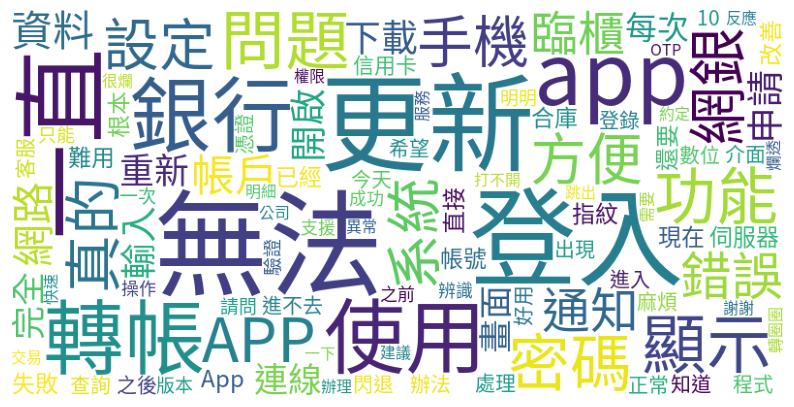

In [ ]:
from collections import Counter

FontPath = 'SourceHanSansTW-Regular.otf' # 設定字型
wordcloud = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words = 100)

# 以斷詞後的詞彙統計出現次數，製作文字雲

# 將所有 words 欄位展平成一個 list
all_words = [word for words in udn['words'] for word in words]
freq_dict = Counter(all_words)

wordcloud.generate_from_frequencies(freq_dict)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## 3. Lexicon-based / 人工給定主題的主題模型

#### 用各個頻分常見的詞來作為主題的代表詞

In [ ]:
## 定義主題 好棒棒的評論
sport_cnt = udn.loc[udn['score'] == 5,:]['words'].explode().value_counts().head(100)
sport_cnt.index

Index(['方便', '好用', '更新', '轉帳', '功能', '不錯', '使用', '介面', '銀行', '無法', '操作', '實用',
       '問題', 'APP', '看看', '謝謝', 'app', '加油', '手機', '合庫', '指紋', '顯示', '服務',
       '一直', '希望', '快速', '改版', '真的', '登入', '網銀', '正常', '直接', 'Good', '設定',
       '便利', 'good', '親切', '安全', 'App', '辨識', '建議', '還好', '新增', '查詢', '很棒',
       '使用者', '進步', '簡單', '行動', '現在', '選擇', '知道', '繼續', '明細', '選項', '系統', '畫面',
       '網路', '麻煩', 'pay', '台灣', '已經', '自動', '資料', '錯誤', '覺得', '客服', '處理', '辦法',
       '開啟', '金融', '帳號', '改善', '之後', '比較', '反應', 'Android', '重新', '今天', '解決',
       '需要', '頁面', '10', '投資', '清楚', '感謝', '感覺', '密碼', 'ok', '簡單明瞭', '合作金庫',
       '行員', '進入', '通知', '登錄', '截圖', '餘額', '成功', '業務', 'VISA'],
      dtype='object', name='words')

In [27]:
stock_cnt = udn.loc[udn['score'] == 4,:]['words'].explode().value_counts().head(200)
pprint(" ".join(stock_cnt.index))

('無法 使用 登入 更新 app 設定 功能 方便 Android 通知 請問 銀行 希望 定存 問題 10 一直 建議 顯示 交易 正常 不錯 已經 '
 '伺服器 每次 App 好用 轉帳 資料 目前 之前 APP 支援 開啟 指紋 帳戶 憑證 新增 優惠 修改 直接 辨識 pay 手機 權限 增加 錯誤 '
 '今天 進步 介面 自動 截圖 合庫 一下 常用 需要 謝謝 線上 不到 解鎖 改善 螢幕 客服 出現 之後 操作 新版 台幣 回覆 終於 失敗 解決 '
 '重新 台灣 閃退 Pixel 黃金 一點 遮蔽 煩請 分行 用心 這裡 買賣 改版 android 訊號 選項 升級 收款 每月 入款 系統 加油 下載 '
 '出入 至少 之內 只能 畫面 輸入 不用 桌面 速度 綜存轉 部份 生物 面部 真是 帳號 驗證 郵局 習慣 額度 XXXX 連結 代繳 零存整付 裡面 '
 '存戶 評價 瓦斯 知道 一顆 用戶 原本 反應 密碼 完成 貴行 感謝 登錄 申請 打開 活存 感覺 美金 icon 合作金庫 30 辦法 有點 是否 '
 '修正 服務 代號 取消 網路 連線 明白 將登 加總 次數 一目瞭然 兆豐 第一 編輯 優利 基金 跟上 入時 改為 圖形 加入 隱藏 線條 跨轉 加強 '
 '安全性 入帳 爛死 刊登 跨提 容易 免費 理財 全部都是 投資 明有 回報 美中不足 提醒 帳的 盪掉 分帳 名目 能夠 OTP 剩餘次數 '
 '2000USD 數位 成功 初次 一段時間 過了 若要 綁定 2023 Note5 應該')


In [28]:
score3 = udn.loc[udn['score'] == 3,:]['words'].explode().value_counts().head(200)
pprint(" ".join(score3.index))

('登入 更新 無法 一直 使用 app 顯示 轉帳 功能 密碼 通知 銀行 問題 希望 手機 定存 下載 請問 App 錯誤 網銀 快速 麻煩 今天 已經 '
 '系統 畫面 重新 進入 改善 資料 方便 之前 設定 權限 輸入 是否 謝謝 每次 開啟 APP 10 伺服器 指紋 截圖 正常 合庫 失敗 驗證 解決 '
 '增加 跳出 信用卡 交易 查詢 登出 辨識 真的 支援 開放 台幣 網路 只能 出現 行動 帳號 一下 付款 入帳 線上 現在 軟體 版本 程式 盡快 '
 '一次 連線 狀況 存款 異常 明細 安裝 服務 打不開 之後 轉圈圈 看到 目前 即時 明明 登錄 應該 介面 人員 處理 需要 圖形 辦理 帳號密碼 '
 '操作 反應 直說 金額 辦法 生物 讀取 內容 安卓 裡面 帳戶 餘額 同步 轉出 貴行 直接 進不去 選項 解鎖 知道 刷卡 代號 很慢 簡訊 完全 '
 '最近 登入後 覺得 訊息 取消 .... 還要 進步 成功 扣款 偵測 用戶 返回 過了 重新安裝 時間 工程師 關閉 管理 客服 買賣 速度 備註 '
 '難用 修正 推播 新莊 分行 應用程式 允許 電話 提醒 SSL 匯款 幾天 合作金庫 電腦 正確 修復 首頁 外幣 更改 空間 選擇 頁面 能否 不行 '
 '外匯 繳款 01 最後 確定 行員 官網 建議 情況 憑證 黃金 更好 无法 加油 實在 不好 要求 一下子 強制 變更 打開 移除 新版 載入 學學 '
 '開機 主頁 上面 OTP')


In [29]:
score2 = udn.loc[udn['score'] == 2,:]['words'].explode().value_counts().head(200)
pprint(" ".join(score2.index))

('登入 無法 更新 一直 轉帳 app 使用 銀行 顯示 設定 重新 功能 指紋 通知 網銀 輸入 系統 開啟 問題 申請 密碼 資料 APP 錯誤 帳戶 '
 '帳號 失敗 明細 交易 約定 手機 臨櫃 方便 完全 進入 下載 出現 直接 同步 截圖 真的 希望 現在 介面 處理 伺服器 辦法 每次 信用卡 '
 '使用者 還要 麻煩 今天 改善 網路 已經 OTP 圖形 請問 連線 知道 閃退 App 正常 程式 金額 建議 時間 之前 轉出 讀取 跳出 之後 '
 '盡快 謝謝 登錄 簡訊 不好 憑證 進不去 行動 只能 辨識 快速 增加 當機 Android 合庫 定存 日期 畫面 異常 訊息 不到 一次 設計 '
 '需要 第一次 打不開 成功 突然 操作 連不上 修正 入帳 10 .... 客服 QR 認證 查詢 不讓 服務 連接 驗證 穩定 權限 公司 登出 根本 '
 '支援 首頁 東西 開通 欄位 覺得 版本 消費 幾天 扣款 快點 人員 不用 不錯 轉轉 打開 匯款 太久 繳費 收不到 是否 掃描 目前 地方 優化 '
 '造成 一下 直說 開放 常用 自動 存款 不行 讀卡機 動畫 容易 辦理 很慢 關閉 最近 哪裡 一點 真是 不想 奇怪 解鎖 修復 貴行 升級 '
 '帳號密碼 我要 換新 速度 網頁 半天 修好 有點 強制 更好 載入 幾次 認證碼 判斷 跟上 告知 習慣 選項 刷卡 金融 符合 鎖住 帳單 最難 '
 '台灣 多久 難用 時代 進出 以前 商店')


In [24]:
score1 = udn.loc[udn['score'] == 1,:]['words'].explode().value_counts().head(200)
pprint(" ".join(score1.index))

('無法 更新 登入 一直 app 銀行 轉帳 使用 問題 密碼 APP 顯示 真的 網銀 臨櫃 系統 錯誤 功能 手機 帳戶 難用 網路 申請 下載 完全 '
 '連線 資料 還要 畫面 每次 輸入 設定 根本 開啟 伺服器 現在 失敗 合庫 帳號 通知 重新 已經 App 客服 直接 信用卡 改善 數位 查詢 '
 '進不去 之後 程式 閃退 知道 辦法 處理 登錄 指紋 麻煩 出現 一次 明明 很爛 憑證 方便 只能 介面 版本 爛透 驗證 成功 打不開 轉圈圈 '
 '爛死 網頁 10 辦理 今天 進入 公司 不行 異常 東西 支援 不想 一下 反應 約定 OTP 開戶 一堆 正常 之前 幹嘛 需要 時間 一點 不好 '
 '跳出 辨識 超級 權限 操作 合作金庫 人員 同步 訊息 安裝 第一次 請問 希望 不到 線上 爛到 突然 綁定 解鎖 入帳 設計 真是 直說 幾次 '
 '不用 明細 最爛 一顆 客戶 餘額 資訊 使用者 正確 裝置 別家 金額 行動 服務 根本無法 交易 存款 看到 這是 頁面 強制 當機 軟體 用過 '
 '電腦 打開 解決 改版 垃圾 簡訊 造成 電話 建議 金融 登出 夠爛 爛的 連不上 行員 台灣 傻眼 繳款 比較 Android 快速 盡快 重新安裝 '
 '.... 匯款 ATM 有夠 帳單 困擾 速度 選項 分行 發生 有沒有 全部 體驗 要求 改進 提供 目前 更改 讀取 常用 誇張 變成 預期 開通 '
 '所有 工程師 最難 最後 定存 永遠 代號')


從 custom_topic_word 的所有值中，整理出不重複的詞彙（vocabularies），並以 NumPy 陣列的形式儲存。

利用 CountVectorizer 的 vocabulary 參數來篩選、製作 DTM

## 4. LDA 主題模型
Latent Dirichlet allocation 簡稱 LDA，是一種主題模型，他可以將資料集中每篇文檔的主題按照機率分佈，他是無監督學習法，訓練時不需要手動標註，只需要給文檔集、主題數，也可以根據一些參數(alpha、Beta)來改變模型訓練的結果，以下使用 gensim 套件來示範如何訓練 LDA 模型。

### **4.1 正式處理評論**

將斷詞後的`doc['words']`轉換成list

In [35]:
docs = udn['words'].to_list()
docs[0]

['更新', '完全', '登入', '立即', '改善']

建立並過濾詞彙表（dictionary），只保留特定條件的詞彙

In [38]:
dictionary = Dictionary(docs)

dictionary.filter_extremes(no_below=5, no_above=0.99)
corpus = [dictionary.doc2bow(doc) for doc in docs]
print(dictionary)

2025-05-18 17:47:04,792 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2025-05-18 17:47:04,820 : INFO : built Dictionary<4220 unique tokens: ['完全', '改善', '更新', '登入', '立即']...> from 3006 documents (total 26424 corpus positions)
2025-05-18 17:47:04,821 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<4220 unique tokens: ['完全', '改善', '更新', '登入', '立即']...> from 3006 documents (total 26424 corpus positions)", 'datetime': '2025-05-18T17:47:04.821149', 'gensim': '4.3.3', 'python': '3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'created'}
2025-05-18 17:47:04,826 : INFO : discarding 3465 tokens: [('立即', 4), ('手勢', 3), ('員工', 3), ('大哥', 1), ('搞錯', 4), ('平安', 2), ('一通', 1), ('亂改', 1), ('更本', 2), ('沒測', 1)]...
2025-05-18 17:47:04,826 : INFO : keeping 755 tokens which were in no less than 5 and no more than 2975 (=99.0%) documents
2025-05-18 17:47:04,828 : INFO : resulting dictionar

Dictionary<755 unique tokens: ['完全', '改善', '更新', '登入', '圖形']...>


參數說明：
- no_below=5	出現在少於 5 篇文章中的詞會被移除
- no_above=0.99	出現在超過 99% 文件中的詞會被移除

### **4.2 開始訓練 LDA topic model**

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。

In [39]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=10, # 生成幾個主題數
    random_state=2024, # 亂數
)

2025-05-18 17:47:08,191 : INFO : using symmetric alpha at 0.1
2025-05-18 17:47:08,192 : INFO : using symmetric eta at 0.1
2025-05-18 17:47:08,193 : INFO : using serial LDA version on this node
2025-05-18 17:47:08,194 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 3006 documents, updating model once every 2000 documents, evaluating perplexity every 3006 documents, iterating 50x with a convergence threshold of 0.001000
2025-05-18 17:47:08,196 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-05-18 17:47:08,197 : INFO : PROGRESS: pass 0, at document #2000/3006
2025-05-18 17:47:08,591 : INFO : merging changes from 2000 documents into a model of 3006 documents
2025-05-18 17:47:08,593 : INFO : topic #7 (0.100): 0.050*"更新" + 0.045*"使用" + 0.022*"APP" + 0.019*"一直" + 0.014*"顯示" + 0.013*"網銀" + 0.013*"好用" + 0.011*"進不去" + 0.011*"無法" + 0.011*"轉帳"
2025-05-18 17:

### **4.3 查看 LDA 主題代表字** <br>

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>


In [40]:
ldamodel.print_topics()

2025-05-18 17:47:11,834 : INFO : topic #0 (0.100): 0.051*"方便" + 0.032*"銀行" + 0.027*"真的" + 0.023*"程式" + 0.021*"客服" + 0.020*"申請" + 0.020*"超級" + 0.018*"資料" + 0.017*"問題" + 0.016*"手機"
2025-05-18 17:47:11,835 : INFO : topic #1 (0.100): 0.030*"通知" + 0.027*"功能" + 0.025*"銀行" + 0.021*"帳戶" + 0.019*"轉帳" + 0.017*"知道" + 0.016*"辦理" + 0.015*"APP" + 0.014*"金額" + 0.013*"問題"
2025-05-18 17:47:11,836 : INFO : topic #2 (0.100): 0.046*"登入" + 0.040*"無法" + 0.039*"app" + 0.021*"轉帳" + 0.020*"銀行" + 0.019*"截圖" + 0.016*"申請" + 0.015*"臨櫃" + 0.013*"密碼" + 0.012*"一直"
2025-05-18 17:47:11,837 : INFO : topic #3 (0.100): 0.060*"更新" + 0.043*"一直" + 0.034*"轉帳" + 0.022*"連線" + 0.016*"方便" + 0.016*"伺服器" + 0.015*"不到" + 0.015*"app" + 0.012*"網銀" + 0.012*"無法"
2025-05-18 17:47:11,837 : INFO : topic #4 (0.100): 0.045*"銀行" + 0.035*"轉帳" + 0.023*"通知" + 0.022*"帳戶" + 0.018*"數位" + 0.018*"功能" + 0.017*"登入" + 0.015*"設定" + 0.014*"還要" + 0.014*"入帳"
2025-05-18 17:47:11,837 : INFO : topic #5 (0.100): 0.029*"使用" + 0.028*"登入" + 0.025*"一直" + 0.025*"下載" 

[(0,
  '0.051*"方便" + 0.032*"銀行" + 0.027*"真的" + 0.023*"程式" + 0.021*"客服" + 0.020*"申請" + 0.020*"超級" + 0.018*"資料" + 0.017*"問題" + 0.016*"手機"'),
 (1,
  '0.030*"通知" + 0.027*"功能" + 0.025*"銀行" + 0.021*"帳戶" + 0.019*"轉帳" + 0.017*"知道" + 0.016*"辦理" + 0.015*"APP" + 0.014*"金額" + 0.013*"問題"'),
 (2,
  '0.046*"登入" + 0.040*"無法" + 0.039*"app" + 0.021*"轉帳" + 0.020*"銀行" + 0.019*"截圖" + 0.016*"申請" + 0.015*"臨櫃" + 0.013*"密碼" + 0.012*"一直"'),
 (3,
  '0.060*"更新" + 0.043*"一直" + 0.034*"轉帳" + 0.022*"連線" + 0.016*"方便" + 0.016*"伺服器" + 0.015*"不到" + 0.015*"app" + 0.012*"網銀" + 0.012*"無法"'),
 (4,
  '0.045*"銀行" + 0.035*"轉帳" + 0.023*"通知" + 0.022*"帳戶" + 0.018*"數位" + 0.018*"功能" + 0.017*"登入" + 0.015*"設定" + 0.014*"還要" + 0.014*"入帳"'),
 (5,
  '0.029*"使用" + 0.028*"登入" + 0.025*"一直" + 0.025*"下載" + 0.024*"無法" + 0.024*"更新" + 0.024*"難用" + 0.019*"指紋" + 0.016*"app" + 0.016*"設定"'),
 (6,
  '0.059*"無法" + 0.034*"使用" + 0.030*"轉帳" + 0.028*"顯示" + 0.021*"一直" + 0.020*"更新" + 0.016*"伺服器" + 0.014*"登入" + 0.014*"問題" + 0.013*"設定"'),
 (7,
  '0.033*"更新" + 

## 5. 視覺化呈現



在本專案中，我們利用 LDAvis 對合作金庫 App 使用者評論進行主題模型視覺化。透過互動式圖表，可以：

- 直觀觀察不同主題（如登入問題、密碼重設、金融業務等）在評論中的分布情形
- 分析各主題間的相似性與差異性，協助辨識用戶主要關注的議題
- 進一步探索每個主題的代表性關鍵詞，了解用戶在不同主題下的具體反饋內容

這有助於產品團隊針對用戶痛點進行優化，並追蹤不同版本或時期下主題分布的變化。



In [ ]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 6,
    id2word=dictionary,
    random_state = 6969,
    passes = 10 # 訓練次數
    )

2025-05-18 17:59:15,632 : INFO : using symmetric alpha at 0.16666666666666666
2025-05-18 17:59:15,633 : INFO : using symmetric eta at 0.16666666666666666
2025-05-18 17:59:15,633 : INFO : using serial LDA version on this node
2025-05-18 17:59:15,636 : INFO : running online (multi-pass) LDA training, 6 topics, 10 passes over the supplied corpus of 3006 documents, updating model once every 2000 documents, evaluating perplexity every 3006 documents, iterating 50x with a convergence threshold of 0.001000
2025-05-18 17:59:15,636 : INFO : PROGRESS: pass 0, at document #2000/3006
2025-05-18 17:59:16,080 : INFO : merging changes from 2000 documents into a model of 3006 documents
2025-05-18 17:59:16,081 : INFO : topic #4 (0.167): 0.036*"方便" + 0.029*"一直" + 0.024*"銀行" + 0.021*"無法" + 0.017*"連線" + 0.017*"問題" + 0.014*"app" + 0.014*"網路" + 0.013*"網銀" + 0.012*"更新"
2025-05-18 17:59:16,082 : INFO : topic #3 (0.167): 0.045*"更新" + 0.027*"一直" + 0.025*"登入" + 0.025*"app" + 0.020*"無法" + 0.015*"程式" + 0.014*"問題" 

In [77]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.240447 -0.068835       1        1  28.155012
2      0.108587 -0.110903       2        1  18.592177
0     -0.144094 -0.145890       3        1  17.044376
4     -0.219774 -0.021728       4        1  13.813329
1     -0.084389  0.172476       5        1  11.518941
3      0.099222  0.174881       6        1  10.876165, topic_info=    Term        Freq       Total Category  logprob  loglift
2     更新  590.000000  590.000000  Default  30.0000  30.0000
11    無法  625.000000  625.000000  Default  29.0000  29.0000
187   通知  167.000000  167.000000  Default  28.0000  28.0000
3     登入  556.000000  556.000000  Default  27.0000  27.0000
59    方便  129.000000  129.000000  Default  26.0000  26.0000
..   ...         ...         ...      ...      ...      ...
157   東西   17.944498   47.773611   Topic6  -4.8578   1.2394
141   操作   18.701195   58.587121   Topic6  -4.8165   1.0767
23    問題   22.017706  190.775478   Topic6  -4.6532   0.0593
15    定存   16.650123   45.928706   Topic6  -4.9327   1.2039
143   每次   17.829124  130.345311   Topic6  -4.8643   0.2292

[404 rows x 6 columns], token_table=      Topic      Freq Term
term                      
471       6  0.967155   30
752       1  0.961556  30%
609       1  0.931023   5%
91        1  0.103911  APP
91        2  0.202354  APP
...     ...       ...  ...
171       3  0.166703   體驗
171       5  0.700152   體驗
348       4  0.906629   黃金
642       1  0.931036   黑屏
672       1  0.949279   點開

[687 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 1, 5, 2, 4])

### 主題說明

- **主題一：無法登入**（負面）
    - 相關於登入失敗、驗證問題等負面回饋。
- **主題二：忘記密碼／難以找回**（負面）
    - 主要反映密碼遺失、找回困難等問題。
- **主題三：轉帳金融**（中性）
    - 討論轉帳、交易、金融功能等相關內容，評價較為中性。
- **主題四：使用方便**（唯一好評）
    - 強調操作便利、介面友善等正面評價。
- **主題五：使用體驗**（中性）
    - 關於整體使用感受，包含正面與負面意見，整體偏中性。
- **主題六：負面使用體驗**
    - 針對操作不便、系統錯誤等負面經驗的回饋。

lambda 的意義: <https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf>

In [78]:
pyLDAvis.save_html(p, "lda_zh.html")

## 6. GuidedLDA 主題模型

GuidedLDA（引導式 LDA）是一種半監督主題模型方法，允許我們透過人工指定的「種子詞」來引導主題的生成。這種方法結合了無監督學習的彈性與專家知識的導入，能讓模型更聚焦於我們關心的主題領域。

在本專案中，我們根據合作金庫 App 使用者評論的常見議題（如登入困難、系統錯誤、操作體驗、轉帳功能、客服回應等），設計了多組主題種子詞，並利用 GuidedLDA 進行主題建模。這有助於：

- 強化模型對特定主題的辨識能力
- 讓主題結果更貼近實際應用需求
- 輔助後續主題分布、趨勢分析與視覺化

以下將展示 GuidedLDA 的建模流程與主題詞彙結果。

In [79]:
import guidedlda

In [80]:
word2id = dictionary.token2id

In [102]:
seed_topic_list = [
    # 登入困難與驗證問題
    ["登入", "密碼", "驗證", "OTP", "指紋", "登錄", "帳號", "解鎖", "憑證"],

    # 系統錯誤與閃退崩潰
    ["錯誤", "失敗", "閃退", "當機", "無法", "載入", "跳出", "伺服器", "系統"],

    # 使用體驗差與操作不便
    ["難用", "介面", "複雜", "輸入", "設計", "不行", "不好", "直覺"],

    # 轉帳與功能問題
    ["轉帳", "查詢", "交易", "功能", "不到", "失敗",  "操作"],

    # 客戶服務與問題回應
    ["客服", "處理", "等待", "回覆", "聯絡", "問題", "電話"]
]

In [103]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [104]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [105]:
model = guidedlda.GuidedLDA(n_topics=5, n_iter=100, random_state=5278, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2025-05-18 18:07:36,256 : INFO : n_documents: 3006
2025-05-18 18:07:36,257 : INFO : vocab_size: 755
2025-05-18 18:07:36,257 : INFO : n_words: 21241
2025-05-18 18:07:36,258 : INFO : n_topics: 5
2025-05-18 18:07:36,259 : INFO : n_iter: 100
2025-05-18 18:07:36,261 : WARNING : all zero row in document-term matrix found
2025-05-18 18:07:36,339 : INFO : <0> log likelihood: -189910
2025-05-18 18:07:36,405 : INFO : <20> log likelihood: -133640
2025-05-18 18:07:36,471 : INFO : <40> log likelihood: -132462
2025-05-18 18:07:36,537 : INFO : <60> log likelihood: -131871
2025-05-18 18:07:36,604 : INFO : <80> log likelihood: -131249
2025-05-18 18:07:36,668 : INFO : <99> log likelihood: -131077


In [106]:
# 整理／顯示主題模型結果
n_top_words = 10
topic_word = model.topic_word_
# 取得corpus全部的詞彙表
vocab = tuple(dictionary.token2id.keys())

for i, topic_dist in enumerate(topic_word):
    # 依照詞語機率從小到大排序，找出每個主題的前十個關鍵詞
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_ # 文件-主題 分佈
term_freq = tuple(dictionary.cfs.values()) # 每個詞在整個語料中出現的總次數
doc_len = [sum(v for k, v in doc) for doc in corpus] # 每篇文章的長度

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 登入 更新 密碼 無法 一直 指紋 app 設定 錯誤 輸入
Topic 1: 無法 一直 更新 登入 使用 伺服器 連線 系統 顯示 失敗
Topic 2: 銀行 app 申請 難用 APP 臨櫃 真的 網銀 轉帳 帳戶
Topic 3: 轉帳 功能 通知 銀行 方便 查詢 無法 app 帳戶 帳號
Topic 4: 更新 登入 問題 無法 手機 使用 一直 app 客服 10


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.059271  0.074771       1        1  22.706936
3      0.160742  0.167816       2        1  21.931478
1     -0.234599  0.014563       3        1  21.638019
2      0.244447 -0.134225       4        1  18.451624
4     -0.111319 -0.122925       5        1  15.271943, topic_info=    Term        Freq       Total Category  logprob  loglift
11    無法  752.000000  752.000000  Default  30.0000  30.0000
3     登入  642.000000  642.000000  Default  29.0000  29.0000
52    一直  503.000000  503.000000  Default  28.0000  28.0000
17    密碼  190.000000  190.000000  Default  27.0000  27.0000
75    銀行  364.000000  364.000000  Default  26.0000  26.0000
..   ...         ...         ...      ...      ...      ...
75    銀行   36.991338  364.666622   Topic5  -4.4739  -0.4091
138   網銀   28.995372  170.864314   Topic5  -4.7174   0.1054
103   顯示   28.995372  210.566908   Topic5  -4.7174  -0.1035
137   合庫   24.997389  108.947425   Topic5  -4.8658   0.4071
44    畫面   22.998397  113.806385   Topic5  -4.9491   0.2801

[354 rows x 6 columns], token_table=      Topic      Freq Term
term                      
266       2  0.159519   10
266       3  0.203024   10
266       5  0.638074   10
471       5  0.994983   30
752       1  0.991817  30%
...     ...       ...  ...
140       2  0.375267   麻煩
140       3  0.075053   麻煩
140       4  0.125089   麻煩
140       5  0.237669   麻煩
348       2  0.997471   黃金

[560 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3, 5])

In [58]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 台灣 表示 聯盟 日本 去年 今年 選手 今天 球迷 球員
Topic 1: 今天 比賽 球員 勇士 戰績 球隊 籃板 數據 中華隊 助攻
Topic 2: 億元 市場 成長 今年 營收 去年 預期 指數 投資 持續
Topic 3: 中國 美國 表示 國家 報導 總統 俄羅斯 大陸 經濟 烏克蘭
Topic 4: 中國 香港 報導 大陸 表示 人民幣 網友 指出 工作 春節
Topic 5: 公司 市場 企業 表示 全球 大陸 產品 發展 技術 晶片


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.155748 -0.214638       1        1  25.813142
3     -0.048262  0.171333       2        1  21.468324
4     -0.081324  0.216607       3        1  17.476062
5     -0.189095 -0.099519       4        1  15.115054
0      0.156167  0.017777       5        1  13.297527
1      0.318262 -0.091560       6        1   6.829891, topic_info=     Term         Freq        Total Category  logprob  loglift
2648   中國  7105.000000  7105.000000  Default  30.0000  30.0000
1484   今天  3509.000000  3509.000000  Default  29.0000  29.0000
1222   市場  4465.000000  4465.000000  Default  28.0000  28.0000
6990   香港  2186.000000  2186.000000  Default  27.0000  27.0000
2670   公司  3469.000000  3469.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
4816   統計   338.285891   776.945448   Topic6  -5.4286   1.8524
1258   數據   412.127830  1585.046472   Topic6  -5.2311   1.3368
22     交易   360.238900  1164.571885   Topic6  -5.3657   1.5105
427    最後   305.356377   931.746848   Topic6  -5.5310   1.5683
508    表現   369.219676  2371.464599   Topic6  -5.3411   0.8240

[446 rows x 6 columns], token_table=      Topic      Freq Term
term                      
2008      2  0.128948   一名
2008      3  0.723720   一名
2008      5  0.119277   一名
2008      6  0.029013   一名
986       6  1.001568   三分
...     ...       ...  ...
6990      3  0.973563   香港
6990      6  0.014176   香港
2860      3  0.054743   體育
2860      5  0.946270   體育
580       5  1.000711   龍隊

[875 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 6, 1, 2])

## 7. LDA主題分布應用：觀察每日主題文章佔比變化

在訓練完LDA主題模型後，我們可以將訓練好的模型應用於整個評論資料集，推論每篇評論屬於各主題的機率分布。接著，根據評論App版本，進一步觀察主題隨時間的變化趨勢。

這樣的分析有助於：

- 追蹤用戶關注議題的變化
- 發現特定時期或版本下，某些主題的討論熱度是否上升或下降
- 協助產品團隊針對熱門或負面主題進行優化

以下將展示如何將LDA模型推論結果轉換為主題分布，並進行主題趨勢的統計與視覺化。

In [136]:
# 取得每條新聞的主題分佈
topics_doc = best_model.get_document_topics(corpus)

In [137]:
topics_doc[100]

[(0, 0.055565648),
 (1, 0.055574484),
 (2, 0.38794836),
 (3, 0.05595293),
 (4, 0.38878667),
 (5, 0.05617192)]

#### 將 LDA 模型推論後的每篇文件的 主題分布（也就是 𝜃）轉換成一個 NumPy 矩陣（array）

In [138]:
# 把 gensim 的稀疏表示法轉成稀疏矩陣
m_theta = corpus2csc(topics_doc).T.toarray() # 倒置讓shape變為(num_docs, num_topics)
m_theta

array([[0.03333792, 0.03339433, 0.03361683, 0.0334272 , 0.03347511,
        0.83274859],
       [0.19106559, 0.02790345, 0.02784977, 0.02783767, 0.02808873,
        0.69725478],
       [0.02385801, 0.02397895, 0.02393391, 0.48403436, 0.023828  ,
        0.42036673],
       ...,
       [0.24179929, 0.51606607, 0.02388615, 0.02417281, 0.02389338,
        0.17018224],
       [0.02092028, 0.02093452, 0.0209141 , 0.52242094, 0.39397606,
        0.02083412],
       [0.40140942, 0.01401298, 0.17686142, 0.01392097, 0.37983981,
        0.01395544]])

In [139]:
# 將主題的機率分布轉換成主題標籤
udn['topic_label'] = m_theta.argmax(axis=1) + 1

#### 統計一下各個主題的數量

In [140]:
udn['topic_label'].value_counts()

topic_label
6    927
1    564
3    485
4    395
5    334
2    301
Name: count, dtype: int64

In [142]:
udn.head()

,reviewId,score,content,artDate,appVersion,topic_label
0,179e2c16-8898-4086-96ff-b897f0284ac4,1,更新後完全登入不進去，請立即改善。,2017-12-29 18:17:05,3.15,6
1,781b02f8-bc78-4240-bb9e-45b2d9ccd61f,3,希望可以新增圖形手勢或是指紋登入,2017-12-22 16:00:34,3.15,6
2,ed390033-a91c-4146-bde7-d4533145e9ba,1,按五顆星的自己員工逆？ 載入都無法進入的app 有沒有搞錯啊 錢不是這樣花的阿大哥,2017-12-21 12:25:16,3.15,4
3,7eb57a03-e2dc-4bba-a0bd-9a059d6c0254,5,平安，很好。,2017-12-20 16:00:13,3.15,1
4,90a8f503-05a0-4459-9b53-a9d57439cc7b,3,為什麼沒有台幣定存,2017-12-20 08:43:32,3.15,5


#### 查看每天每個主題的文章相對比例（占比）

In [129]:
udn['major_version'] = udn['appVersion'].str.split('.').str[:2].str.join('.')
udn.groupby('major_version')['topic_label'].value_counts(normalize=True)

major_version  topic_label
3.11           6              0.500000
               2              0.250000
               3              0.250000
3.12           6              0.666667
               4              0.333333
                                ...   
3.22           3              0.185393
               1              0.179775
               2              0.162921
               4              0.140449
               5              0.140449
Name: proportion, Length: 65, dtype: float64

In [143]:
date_topic = udn.groupby(udn['appVersion'])['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label,1,2,3,4,5,6
appVersion,,,,,,
3.11,NaN,0.250000,0.250000,NaN,NaN,0.500000
3.12,NaN,NaN,NaN,0.333333,NaN,0.666667
3.13,0.139130,0.113043,0.147826,0.069565,0.130435,0.400000
3.14,0.184211,0.105263,0.197368,0.144737,0.078947,0.289474
3.15,0.084507,0.042254,0.169014,0.154930,0.084507,0.464789


#### 視覺化呈現主題文章趨勢變化

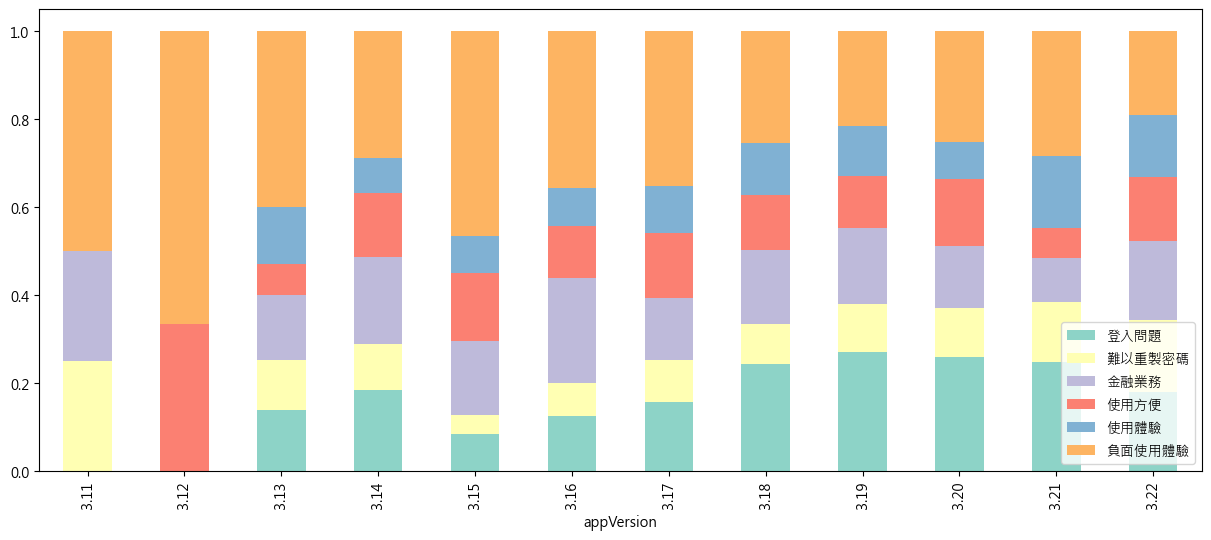

In [149]:
"""主題一 無法登入 (負面)
主題二 忘記密碼 難以找回 (負面)
主題三 轉帳金融 (中性)
主題四 使用方便 (唯一好評)
主題五 使用體驗 (中性)
主題六 負面使用體驗 """

date_topic.columns = [
    "登入問題",
    "難以重製密碼",
    "金融業務",
    "使用方便",
    "使用體驗",
    "負面使用體驗"
]


fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

## 8. 主題分布與特徵詞分析

本節針對合作金庫 App 使用者評論進行更深入的主題特徵分析，探討：

- 不同評分等級下的主題分布差異
- 各主題代表性詞彙與關聯性
- 主題詞彙的權重分布與視覺化
- 主題之間的相似度與差異

透過這些分析，我們可以：
- 識別用戶最關心的功能與問題
- 找出不同評分背後的主要原因
- 協助產品團隊優先改善重要議題

In [1]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker
import pandas as pd
import re
import numpy as np
from collections import defaultdict
import multiprocessing
import jieba
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager


In [2]:
# 讀入中文示範資料集
origin_data = pd.read_csv('merged_data.csv')

In [3]:
origin_data.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,179e2c16-8898-4086-96ff-b897f0284ac4,Google 使用者,https://play-lh.googleusercontent.com/EGemoI2N...,更新後完全登入不進去，請立即改善。,1,0,3.15.1219,2017-12-29 18:17:05,有關本行行動網銀app交易係因帳務主機交易量大處理回應緩慢，致使行動網銀app交易遲緩，未能...,2018-01-11 11:02:41,3.15.1219
1,781b02f8-bc78-4240-bb9e-45b2d9ccd61f,Google 使用者,https://play-lh.googleusercontent.com/EGemoI2N...,希望可以新增圖形手勢或是指紋登入,3,0,3.15.1219,2017-12-22 16:00:34,您好，感謝您寶貴的建議，未來改版會納入考量。,2018-01-03 09:53:23,3.15.1219
2,ed390033-a91c-4146-bde7-d4533145e9ba,Google 使用者,https://play-lh.googleusercontent.com/EGemoI2N...,按五顆星的自己員工逆？ 載入都無法進入的app 有沒有搞錯啊 錢不是這樣花的阿大哥,1,7,3.15.1219,2017-12-21 12:25:16,您好，已於2017/12/20更新版本，請下載使用。,2018-01-03 09:54:09,3.15.1219


In [4]:
# 去除一些不需要的欄位
metaData = origin_data[['content']]

# 只留下中文字
metaData['content'] = metaData['content'].str.replace(r'\n\n','。', regex=True)
metaData['content'] = metaData['content'].str.replace(r'\n','', regex=True)


metaData = metaData.explode('content').reset_index(drop=True)

metaData['content'] = metaData['content'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
metaData = metaData.dropna().reset_index(drop=True)
metaData.head()

,content
0,更新後完全登入不進去請立即改善
1,希望可以新增圖形手勢或是指紋登入
2,按五顆星的自己員工逆載入都無法進入的有沒有搞錯啊錢不是這樣花的阿大哥
3,平安很好
4,為什麼沒有台幣定存


In [5]:

# 中文文章
docs_zh = metaData['content'].tolist()[:500]

# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增 stopwords
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定中文 embedding model
bert_sentence_model = SentenceTransformer("BAAI/bge-m3")

# 將中文文章轉換為 embedding
embeddings = bert_sentence_model.encode(docs_zh, show_progress_bar=True)

# 定義不同 clustering layer 所要使用的模型與方法（就用 default 的 HDBSCAN）
hdbscan_model = HDBSCAN()

# 定義一個適合中文的分詞函數
def tokenize_zh(text):
    words = jieba.lcut(text)
    return words

# 建立一個使用 jieba 分詞的 CountVectorizer
jieba_vectorizer = CountVectorizer(tokenizer=tokenize_zh, stop_words=stopWords, analyzer='word', token_pattern=u"(?u)\\b\\w+\\b")

# 使用 BERTopic 進行主題模型建立
zh_topic_model = BERTopic(embedding_model=bert_sentence_model, vectorizer_model=jieba_vectorizer, verbose=True, top_n_words=30)
topics, probs = zh_topic_model.fit_transform(docs_zh, embeddings)

zh_topic_model.get_topic_info()

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2025-05-18 19:37:51,247 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-18 19:38:01,509 - BERTopic - Dimensionality - Completed ✓
2025-05-18 19:38:01,510 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-18 19:38:01,541 - BERTopic - Cluster - Completed ✓
2025-05-18 19:38:01,546 - BERTopic - Representation - Fine-tuning topics using representation models.
Building prefix dict from c:\Users\hank\Desktop\sb\dict\dict.txt.big ...
Loading model from cache C:\Users\hank\AppData\Local\Temp\jieba.u465ee282b7ba9db18471e8710c3c9621.cache
Loading model cost 0.974 seconds.
Prefix dict has been built successfully.
2025-05-18 19:38:02,591 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,110,-1_ _一直_登入_錯誤,"[ , 一直, 登入, 錯誤, 伺服器, 問題, 顯示, 處理, 異常, 失敗, 憑證, 資...","[系統異常請洽銀行客服人員但一直沒人處理阿, 怎麼一直顯示伺服器錯誤, 更新後就無法登入一直..."
1,0,73,0_登入_無法_ _一直,"[登入, 無法, , 一直, 登錄, 今天, 請, 辦法, 進入, 登, 幾天, 正常, ...","[無法登入, 無法登入, 無法登入]"
2,1,50,1_銀行_信用卡_網銀_登入,"[銀行, 信用卡, 網銀, 登入, 查詢, 成功, , 使用, 合庫, 登, 失敗, 申請...",[為何要查詢信用卡帳單卻要我登入個人網銀明明在你們網頁版只要登入信用卡會員就能查詢在卻不同調...
3,2,43,2_更新_使用_無法_卻,"[更新, 使用, 無法, 卻, 後, , 開啟, 一直, 安裝, 人, 程式, 系統, 問...","[不能更新, 無法更新, 無法更新]"
4,3,36,3_後_更新_無法_登入,"[後, 更新, 無法, 登入, 進不去, , 完全, 之後, 一直, 初始, 停, 初始化...","[更新後無法登入, 更新後無法登入, 更新後無法登入]"
5,4,34,4_轉帳_簡訊_帳號_匯款,"[轉帳, 簡訊, 帳號, 匯款, , 密碼, 無法, 認證碼, 機制, 收不到, 認證, ...","[轉帳收不到簡訊密碼, 更新後不能轉帳, 無法轉帳]"
6,5,32,5_方便_ _好_便利,"[方便, , 好, 便利, 服務, 平安, 加油, 讚, 好用, 行動, 謝謝, 实用, ...","[很方便, 方便, 很方便很好用]"
7,6,26,6_手機_支援_版本_三星,"[手機, 支援, 版本, 三星, 後, 解決, 重新安裝, 出現, , 下載, 更新, 事...",[更新後無法開啟出現不支援此手機我明明是原廠系統沒更改過麻煩改改好嗎更新後仍然出現不支援此手...
8,7,23,7_很爛_ _奇葩_爛,"[很爛, , 奇葩, 爛, 東西, 超爛, 爛到, 搞, 帳號密碼, 一點, 錯誤, 版,...","[爛死了今天早上七八點也登入不進去爛客服也不知跑哪去馬的這麼多人反應爛了也不懂得改進, 真的..."
9,8,22,8_打不開_開啟_ _開,"[打不開, 開啟, , 開, 死當, 程式, 連開, 完全, 改善, 客服, 卡住, 開是...","[打不開, 打不開啊, 打不開]"


In [6]:
zh_topic_model.visualize_topics()

In [7]:
# 估算每個文件對BERTopic每個主題的機率分布
topic_distr, _ = zh_topic_model.approximate_distribution(docs_zh)

100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


In [9]:
# 以第18個文件為例，列出這份文件對每個主題的機率分布
zh_topic_model.visualize_distribution(topic_distr[13])

In [10]:
# 列出主題的代表詞和其對應的權重
zh_topic_model.get_topic(2)

[('更新', 0.17601102111153255),
 ('使用', 0.07746503103225992),
 ('無法', 0.06755337292227993),
 ('卻', 0.06375427002077816),
 ('後', 0.05668109945704502),
 (' ', 0.05219428650268092),
 ('開啟', 0.04481942032820539),
 ('一直', 0.03742030152843072),
 ('安裝', 0.03722836123450204),
 ('人', 0.03722836123450204),
 ('程式', 0.03324976552917237),
 ('系統', 0.031047937979315036),
 ('問題', 0.030165804815225506),
 ('強制', 0.028911360681799895),
 ('下載', 0.02832689959321674),
 ('櫃檯', 0.02553632970592024),
 ('這麼久', 0.02553632970592024),
 ('商店', 0.02349964872663861),
 ('真是', 0.02349964872663861),
 ('找', 0.02349964872663861),
 ('已經', 0.023313433838889466),
 ('說', 0.023313433838889466),
 ('好好', 0.022059285198428313),
 ('越', 0.022059285198428313),
 ('最新版', 0.022059285198428313),
 ('要求', 0.020945646977752166),
 ('修正', 0.020945646977752166),
 ('搞', 0.020038650717368094),
 ('解除', 0.020038650717368094),
 ('閃退', 0.01861418061725102)]

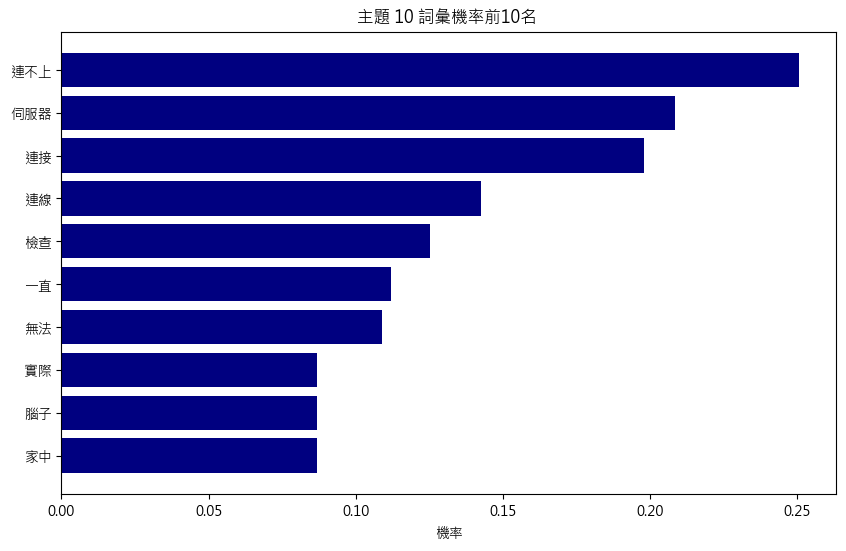

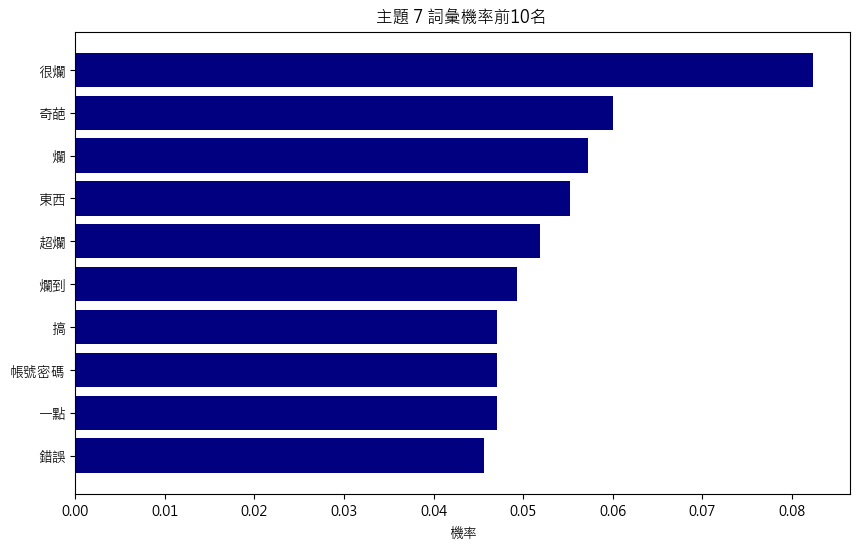

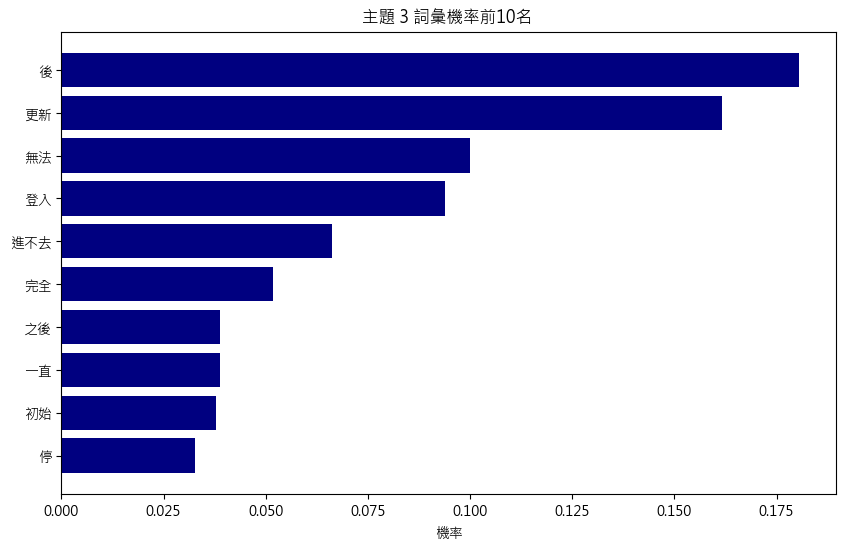

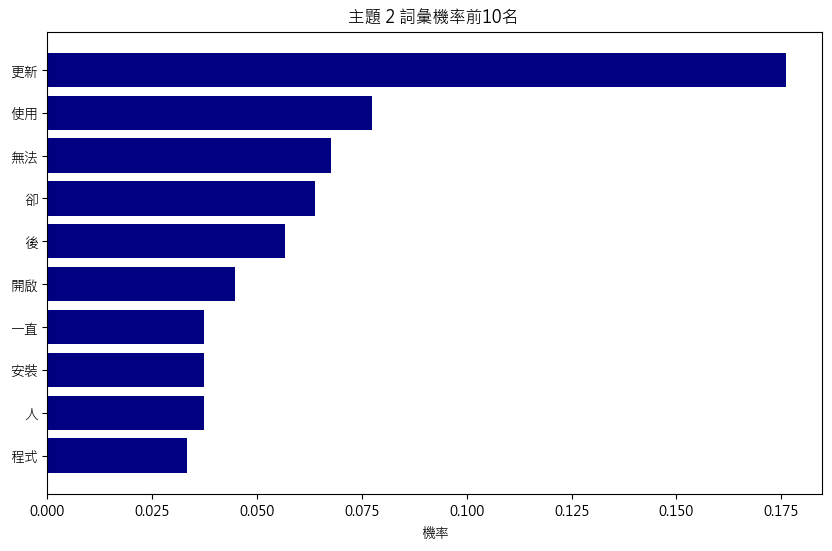

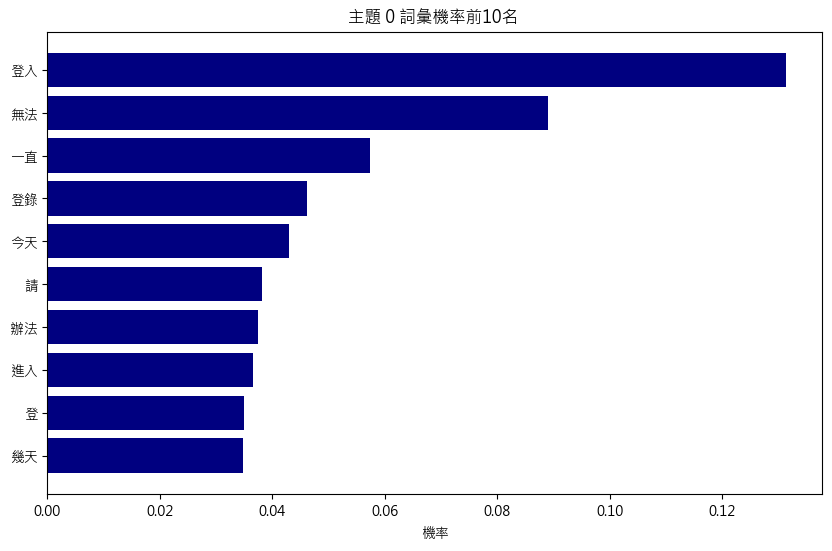

In [30]:
top_distribution = [10,7,3,2,0]
for i in top_distribution:
    # 取得每個主題的關鍵詞
    topic_words = zh_topic_model.get_topic(i)
    
    # 轉換為DataFrame
    df = pd.DataFrame(topic_words, columns=['word', 'prob'])
    df = df[df['word'] != ' ']
    
    # 根據prob排序並選出前10名
    top_10 = df.sort_values('prob', ascending=False).head(10)
    
    # 畫出長條圖
    plt.figure(figsize=(10,6))
    plt.barh(top_10['word'], top_10['prob'], color='navy')
    plt.xlabel('機率')
    plt.title(f'主題 {i} 詞彙機率前10名 ')
    plt.gca().invert_yaxis()
    plt.show()

## 9. 社群網路分析

針對合作金庫 App 3.20-3.22 版本的使用者評論進行社群網路分析，探討：

- 使用者與不同版本之間的互動關係
- 評分傾向（正面/負面）的分布情形
- 評論連結的強度與特性

透過社群網路視覺化，我們可以：

- 識別用戶對各版本的評價傾向
- 觀察用戶反饋的版本集中度
- 發現潛在的問題模式與改善機會

這些洞察有助於產品團隊：

- 追蹤版本迭代的用戶反應
- 評估版本更新的影響
- 制定針對性的改善策略

In [2]:
import pandas as pd
import numpy as np
import pyvis
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Image

In [37]:

select_versions = udn[udn['appVersion'].isin(['3.22', '3.21', '3.20'])]
select_versions


,reviewId,score,content,artDate,appVersion,userName,words
2306,e9f9244d-3a9c-4882-9687-d08d802619c1,1,很難操作晃半天進不去呢,2022-12-26 16:09:22,3.20,李妹蘭,"[很難, 操作, 半天, 進不去]"
2307,5a3f7d7c-ea2b-4fbd-8fe9-8b2b1c208d91,1,開啟入帳通知，結果金錢入帳都不會通知（對方還要備註薪資），難道被盜用人頭張戶，銀行負責嗎？都...,2022-12-16 21:37:41,3.20,林奕睿,"[開啟, 入帳, 通知, 金錢, 入帳, 通知, 對方, 還要, 備註, 薪資, 被盜, 用..."
2308,73f07fd6-1417-43ce-9a74-40093563c864,1,為啥我圖形登入，每次都要登入兩次？第一次完全沒反應，都要我先按取消再登入一次，太不方便了吧！,2022-12-16 00:52:07,3.20,阿樂,"[圖形, 登入, 每次, 登入, 兩次, 第一次, 完全, 反應, 取消, 登入, 一次, 方便]"
2309,e66dfdd0-77ec-478c-a904-c6d28300e9f9,1,程式一直繞圈圈，跑不動。顯示無法與伺服器連線 一直停在更新中5%,2022-12-07 07:38:34,3.20,晴天魚,"[程式, 一直, 繞圈圈, 跑不動, 顯示, 無法, 伺服器, 連線, 一直, 更新, 5%]"
2310,c3541a19-0abd-443b-b2f2-707c8e7b4365,1,爛+爛+爛+爛+爛,2022-12-06 22:54:07,3.20,奕德,[]
...,...,...,...,...,...,...,...
3001,256c78ca-38a0-4954-a18b-2824d8c946de,2,"原可轉帳，更新app後，OTP要跳出前都會出現訊息”太久未操做"", 多次試用都一樣",2024-01-03 19:30:13,3.21,Chris Lee,"[原可, 轉帳, 更新, app, OTP, 跳出, 出現, 訊息, 太久, 未操, 試用]"
3002,ef7f2908-14de-4ef1-9e81-c41dc7c99f4e,3,幾乎每次登入都要來一次同步資料真的非常浪費時間。,2024-01-03 14:31:06,3.21,Peggy Lee,"[每次, 登入, 要來, 一次, 同步, 資料, 真的, 浪費時間]"
3003,b29d2236-757a-4945-8881-67066dfa3bff,1,一天到晚在更新，所有銀行的app就屬你們最爛…,2024-01-03 08:13:00,3.21,5 A (A5和牛),"[一天到晚, 更新, 所有, 銀行, app, 就屬, 最爛]"
3004,79733990-ecc2-44ff-8c08-01cde53e6fae,3,有夠難用，到底有沒有在認真經營，學學別家銀行啦,2024-01-02 18:45:40,3.21,CY Y,"[有夠, 難用, 有沒有, 認真, 經營, 學學, 別家, 銀行]"


In [ ]:
#parse comment
import random



re_df = select_versions[['userName','appVersion','score']].rename(columns = {'userName':'src','appVersion':'dis','score':'weight'})
re_df = re_df[~re_df['src'].isna()]
re_df = re_df[~re_df['dis'].isna()]
re_df = re_df[~re_df['weight'].isna()]




def convertStatus(s):
  if s >3:
    return 2
  else :
    return -1
re_df['weight'] = re_df['weight'].map(convertStatus)
re_df = re_df.groupby(['src','dis']).sum().reset_index()

# 設定分數低的為紅色
def getColor(w):
  if w>0:
    return 'green'
  else:
    return 'red'
re_df['color'] = re_df.weight.map(getColor)


In [ ]:
import pyvis
from PIL import Image

netWork = pyvis.network.Network(notebook=True, cdn_resources='in_line',directed=True)


person = list(set(+re_df.src.unique().tolist()))
# 移除 url 中的 nan 值，建立 url_clean

netWork.add_nodes(
    nodes = person,
    value = [1 for i in range(len(person))],
    color = ['#66CDAA' for i in range(len(person))],
    title = person
)

for i in re_df.to_numpy():
  netWork.add_edge(i[0],i[1],width = 2,color=i[3])

# 設定layout
netWork.repulsion()

# 產生 HTML 字串
html_content = netWork.generate_html()

# 手動以 utf-8 儲存檔案，避免 cp950 編碼錯誤
with open('network.html', 'w', encoding='utf-8') as f:
    f.write(html_content)


可以看到在社群網路圖片中 在三個版本 3.22 3.21 3.20 中的使用者與版本之間的關聯性
大多數為紅色負面連結
且大多數使用者只會評論一個版本



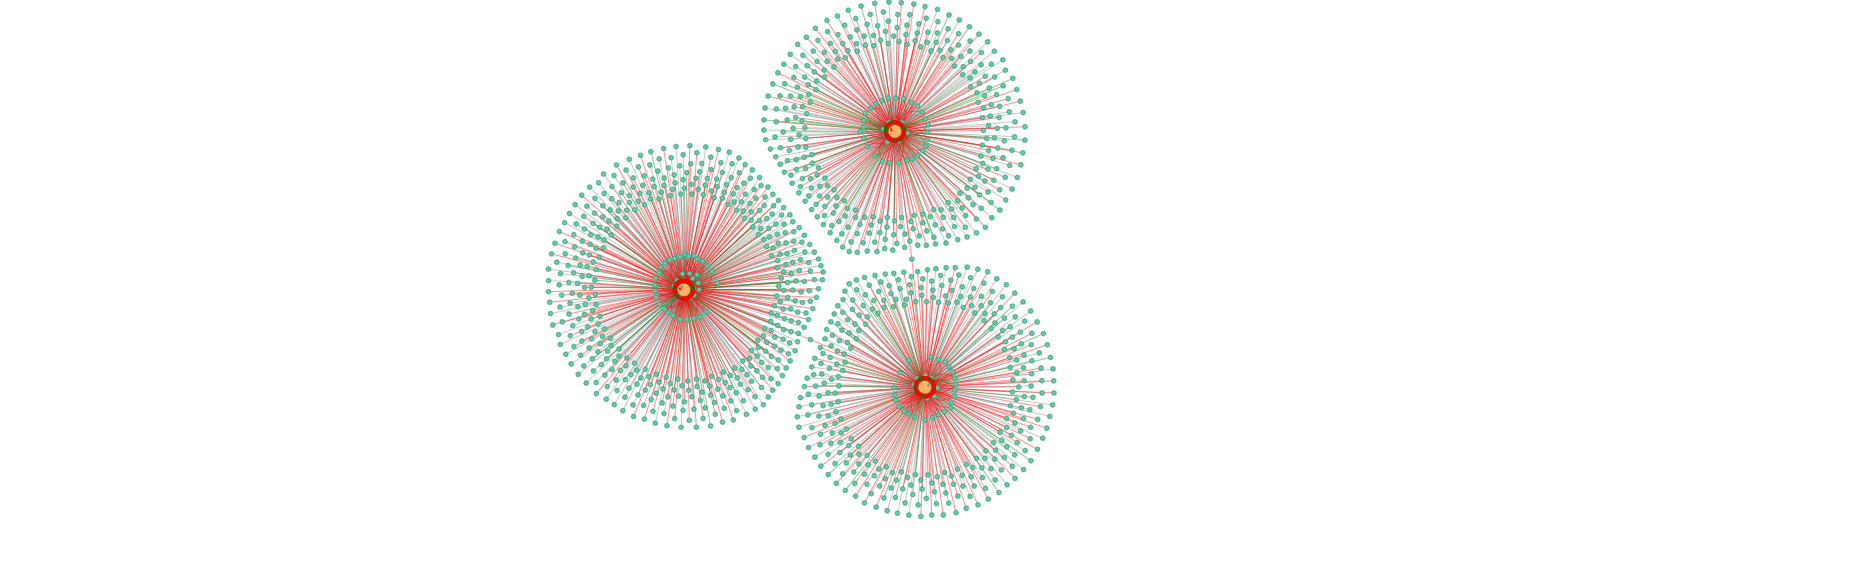

In [40]:
Image.open('network.png')